<font size="5">Calculation and plot the total and projected DOS</font>

In [ ]:
import os
import sys
import re
from mp_api.client import MPRester
from siman import header
from siman.SSHTools import SSHTools
from siman.header import _update_configuration, db
from siman.calc_manage import smart_structure_read
from siman.database import read_database, write_database
import project_sets
from siman.set_functions import read_vasp_sets
from siman.electronic.band_structure import band_structure as bs
from siman.wrappers import waiting_calc_complete as wrap
from siman.wrappers import sets_wrap as swrap

In [10]:
_update_configuration('simanrc.py') # simanrc.py should be in the folder with project 
read_database() # read database if exist
api_key = '***' # your api-key
api_key = '8TZ6AudDxDMLu8h9eCu7LUKMCAA7sTOM'

In [11]:
# Defining the basic parameters for calculations

sp_pack = {'KSPACING': 0.33, 'NPAR':None,'ISTART':None,'NELM':None,'PREC':None,'ALGO':None,
           'KGAMMA':None,'ENCUT':600,'LPLANE':None, 'LREAL':'.FALSE.',
           'EDIFF': 1.e-8}

dos_pack = {'NSW':0, 'LORBIT':12, 
            'ISMEAR':-5, 'LAECHG':'.TRUE.', 
            'EMIN':-10, 'EMAX':14, 
            'NEDOS':2000, 'KSPACING':0.15, 
            'savefile':'d'}

<font size="4">Step 1. Perform self-consistent calculation</font>

In [ ]:
# Download the structure from MP or take another initial data

LiCl = ['mp-1185319']

with MPRester(api_key) as mpr:
    docs = mpr.materials.summary.search(
        material_ids=LiCl
    )

for doc in docs:
    st = doc.structure
    st_name = re.sub(r'([()\\[\]])', r'', st.reduced_formula)
    st_name = st_name + f'_{LiCl[0]}'


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Create siman class Structure with initial geometry

folder_name = os.getcwd() #folder with your project
path_to_POSCAR, path_to_main_folder = bs.create_POSCAR(st, st_name, home_path=folder_name, debug=True)
siman_st = smart_structure_read(path_to_POSCAR)



From create_POSCAR: the file /Users/irinabrodyagina/Desktop/electrolyties/LiCl/LiCl.POSCAR was crested


In [37]:
# Create set with parametres
varset = read_vasp_sets(project_sets.user_vasp_sets, override_global=0)
swrap.create_new_set("sp", "static", sp_pack)


Attention! You have chosen to override set sp
 



In [39]:
# Calculations
wrap.charge_calc(st_name, siman_st, 'sp')

-- Attention!, cluster None is not found, using default razor128 

-- Warning! This calculation was already submitted. Use run = 2 to submit it again 

-- Warning! run = 2, the calculation is resubmitted 

-- check_kpoints(): Kpoint   mesh is:  [6, 6, 3] 

-- check_kpoints(): The actual k-spacings are  ['0.31', '0.31', '0.33'] 

-- POSCAR was written to LiCl//LiCl.sp/1.POSCAR 

-- Attention! ngkpt =  [6, 6, 3]  is adopted from struct_des which you provided for it  LiCl  and kspacing =  0.33 


Calculation db[('LiCl', 'sp', 1)] successfully created

 

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             18536   regular LC104_5.   a.boev PD       0:00      1 (Resources)
             18537   regular LC104_5.   a.boev PD       0:00      1 (Priority)
             18538   regular LC104_5.   a.boev PD       0:00      1 (Priority)
             18539   regular LC104_5.   a.boev PD       0:00      1 (Priority)
             18547   regular relaxati  a.burov PD    

In [ ]:
# Read the results of calculations
res_loop(st_name, 'sp', 1)

--                           |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    


Max. F. tot  (meV/A) =  [16] 

-- db['LiCl_mp-1185319.sp.1']    |  -14.8465  |3.92, 3.92, 6.36|  -130,-130,-269    |   1,17, 17    

Database has been successfully updated



(["db['LiCl_mp-1185319.sp.1']    |  -14.8465  |3.92, 3.92, 6.36|  -130,-130,-269    |   1,17, 17   "],
 [])

<font size="4">Step 2. Perform non-self-consistent calculation with a dense k-grid</font>

In [45]:
# Create set with parametres
varset = read_vasp_sets(project_sets.user_vasp_sets, override_global=0)
swrap.create_new_set("dos", "sp", dos_pack)


Attention! You have chosen to override set dos
 

Warning! You did not change  NSW  in dos set
 



In [ ]:
#Calculations
add_loop(st_name, 'dos', 1, savefile = 'ocx', input_geo_file = path_to_POSCAR,
    it_folder = st_name, run=1)

-- Attention!, cluster None is not found, using default razor128 

-- Warning! This calculation was already submitted. Use run = 2 to submit it again 

-- Bye-bye! 

-- bash: line 1: ./run: No such file or directory 

-- To read results use  res_loop('LiCl_mp-1185319', ['dos'], [1], show = 'fo'  )     # , on 2025-04-30   ; possible options for show: fit, fo, fop, en, mag, magp, smag, maga, occ, occ1, mep, mepp 


Database has been successfully updated



'LiCl_mp-1185319'

In [48]:
# Read the results of calculations
res_loop(st_name, 'dos', 1)

--                           |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    


Max. F. tot  (meV/A) =  [16] 

-- db['LiCl_mp-1185319.dos.1']   |  -14.8465  |3.92, 3.92, 6.36|  -129,-129,-269    |   1,16, 16    

Database has been successfully updated



(["db['LiCl_mp-1185319.dos.1']   |  -14.8465  |3.92, 3.92, 6.36|  -129,-129,-269    |   1,16, 16   "],
 [])

<font size="4">Step 3. Plot the DOS with necessary parameters</font>

In [54]:
from siman.dos_functions import plot_dos


# Save the class with the calculation results in a specific variable
LiCl_DOS = header.db[st_name, 'dos', 1]

a. Total  DOS

-- ------Start plot_dos()----- 

-- LiCl_mp-1185319.dos.1 e_fermi -1.4727 

-- Image saved to  dos/LiCl_mp-1185319.dos.1.dosTotal.png 



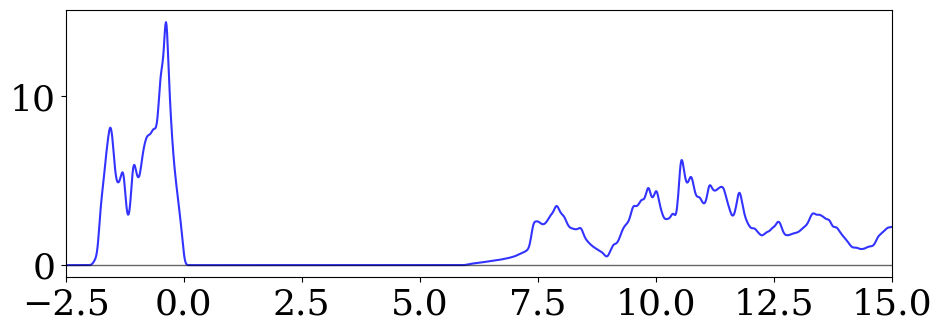

{'name': 'LiCl_mp-1185319.dos.1',
 'filename': 'dos/LiCl_mp-1185319.dos.1.dosTotal',
 'gc': None}

In [58]:
plot_dos(LiCl_DOS, 
         dostype = 'total',
         plot_param={'legend': False, 'figsize': (10, 4), 'xlim':(-2.5, 15),
                     'filename':f'{st_name}_test','fig_format':'png',})

# You  can change any plot parameters in plot_param dict 
# and even save plot in any avalible format

b. Projected  DOS

-- cl1: Atom 1 of type Li is choosen 

-- cl1: Atom numbers: {1: 'Li', 2: 'Li', 3: 'Cl', 4: 'Cl'} 

-- I have found  1 non-equivalent positions for Li : dict_keys([np.int32(0)]) 
-- Atom numbers (from zero!):  {np.int32(0): [0, 1]} 

-- cl1: [[0, 1]] 

-- ------Start plot_dos()----- 

-- LiCl_mp-1185319.dos.1 e_fermi -1.4727 

-- Typat of chosen imp atom in cl1 is  Li 

-- Numbers of local atoms (from one): [1, 3, 4, 4, 4, 2, 2] 

-- Elements of local atoms: ['Li', 'Cl', 'Cl', 'Cl', 'Cl', 'Li', 'Li'] 

-- List of distances [np.float64(0.0), np.float64(2.4), np.float64(2.4), np.float64(2.4), np.float64(2.4), np.float64(3.9), np.float64(3.9)] 

-- Number of surrounding atoms: 6 

-- Orbital is  s 

-- Plotting for s Li 

-- Image saved to  dos/LiCl_mp-1185319_at_Li1.s.Li1.png 



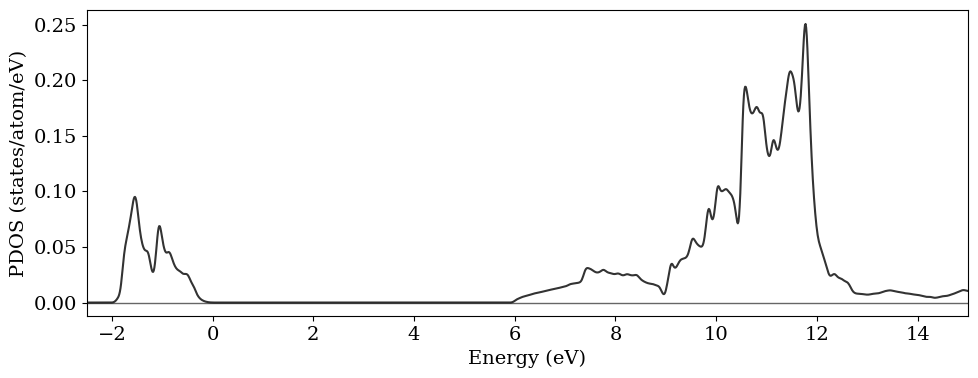

{'name': 'LiCl_mp-1185319.dos.1',
 'filename': 'dos/LiCl_mp-1185319_at_Li1.s.Li1',
 'gc': None}

In [62]:
# For projected DOS for a specific atom type, 
# you need to provide the index of that atom in the structure

#Let's plot the PDOS for Li

iatom_id = LiCl_DOS.end.get_elements().index('Li') + 1

plot_dos(LiCl_DOS, 
        dostype = 'partial',
        iatom = iatom_id,
        plot_param={'legend': False, 'figsize': (10, 4), 'xlim':(-2.5, 15),
                     'filename':f'{st_name}_proj_Li_test','fig_format':'png',}
        )

-- cl1: Atom 1 of type Li is choosen 

-- cl1: Atom numbers: {1: 'Li', 2: 'Li', 3: 'Cl', 4: 'Cl'} 

-- I have found  1 non-equivalent positions for Li : dict_keys([np.int32(0)]) 
-- Atom numbers (from zero!):  {np.int32(0): [0, 1]} 

-- cl1: [[0, 1]] 

-- ------Start plot_dos()----- 

-- LiCl_mp-1185319.dos.1 e_fermi -1.4727 

-- Typat of chosen imp atom in cl1 is  Li 

-- Numbers of local atoms (from one): [1, 3, 4, 4, 4, 2, 2] 

-- Elements of local atoms: ['Li', 'Cl', 'Cl', 'Cl', 'Cl', 'Li', 'Li'] 

-- List of distances [np.float64(0.0), np.float64(2.4), np.float64(2.4), np.float64(2.4), np.float64(2.4), np.float64(3.9), np.float64(3.9)] 

-- Number of surrounding atoms: 6 

-- Orbital is  s 

-- Plotting for s Li 

-- Orbital is  p 

-- Plotting for p Li 



/Users/irinabrodyagina/Desktop/electrolyties/elec_venv/lib/python3.12/site-packages/siman/geo.py:1195: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  for i, (el, pos) in enumerate(zip(st.get_elements(), info['equivalent_atoms'])):


-- Image saved to  dos/LiCl_mp-1185319_at_Li1.sp.Li1.png 



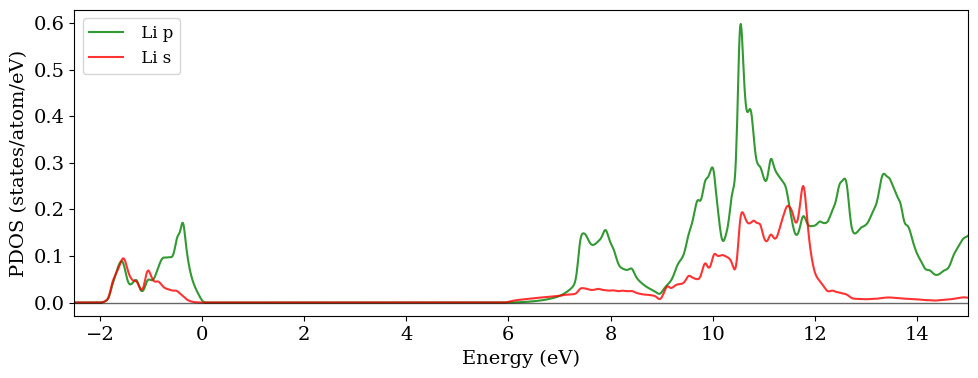

{'name': 'LiCl_mp-1185319.dos.1',
 'filename': 'dos/LiCl_mp-1185319_at_Li1.sp.Li1',
 'gc': None}

In [72]:
# You can also separate the contributions from different orbitals

plot_dos(LiCl_DOS, 
        dostype = 'partial',
        iatom = iatom_id,
        orbitals = ['s', 'p'],
        plot_param={'figsize': (10, 4), 'xlim':(-2.5, 15), 'dashes': (None, None),
                    'filename':f'{st_name}_proj_Li_orbits_test','fig_format':'png',
                    'legend':'upper left'}, color_dict={'s':'r', 'p': 'g'}, labels=['', ''],
        )

# 'dashes': (None, None) - makes the lines monolithic (dotted line by default)
# labels=['', ''] - sets short names in the legend